In [2]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pvtv2 import pvt_v2_b2
import torch.nn.functional as F
import warnings
import torch
from torch import nn
warnings.filterwarnings('ignore')
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torchvision.transforms as transforms
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import numpy as np
import cv2
import glob
from skimage.morphology import binary_erosion, disk
from skimage.segmentation import slic
import keras.backend as K
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import tensorflow as tf
import os
import cv2
import glob
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras import layers

2024-02-05 20:43:52.712325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 20:43:53.027535: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 20:43:54.122057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/

In [3]:
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_original/*.png' )
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_mask/*.png')
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/image/*.jpg')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/mask/*.jpg')
image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train/*.png')
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train_mask/*.png')
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_10percent/breast_train/*.png')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_10percent/breast_train_mask/*.png')


In [4]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [5]:
def create_superpixel_ground_truth(img, ground_truth):

    # Perform superpixel segmentation
    num_segments = 800
    segments = slic(img, n_segments=num_segments, compactness=10)

    image_superpixel = label2rgb(segments, img, kind='avg')
    image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(segments))

    image_boundaries = mark_boundaries(img, segments, color=(255, 0, 0))
    labels = segments.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)  # White pixels in ground truth are inside the region
    outside_mask = (ground_truth == 0)  # Black pixels in ground truth are outside the region
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    # Exclude boundary superpixels
    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        # Check if the superpixel intersects with the boundary
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask, disk(3))
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    num_segments_result = len(np.unique(valid_superpixels))

    # Assign labels and color superpixels
    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = (255, 255, 255)  # Yellow for inside superpixels
            inside_labels.append(label)
        else:
            # color = (128, 128, 128)
            color = (0, 0, 0)  # Blue for outside superpixels
            outside_labels.append(label)
        result[mask] = color

    # Count superpixels that intersect with the boundary
    boundary_intersecting_superpixels = np.unique(labels[boundary_mask])
    num_boundary_intersecting_superpixels = len(boundary_intersecting_superpixels)

    return result

In [6]:
def dice_coef_one_class(y_true, y_pred, smooth=1e-7):
    y_true_inside = K.cast(y_true == 1, 'float32')
    y_pred_inside = y_pred[..., 1]  # Assuming class 1 is the one inside the boundaries.

    intersection = K.sum(y_true_inside * y_pred_inside)
    denom = K.sum(y_true_inside) + K.sum(y_pred_inside)

    return (2. * intersection + smooth) / (denom + smooth)


In [7]:
def iou_one_class(y_true, y_pred, class_index=1, smooth=1):
    y_true_inside = K.cast(y_true == class_index, 'float32')
    y_pred_inside = y_pred[..., class_index]

    intersection = K.sum(y_true_inside * y_pred_inside)
    union = K.sum(y_true_inside) + K.sum(y_pred_inside) - intersection
    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score

In [8]:
def precision_one_class(y_true, y_pred):
    y_true_inside = K.cast(y_true == 1, 'float32')
    y_pred_inside = y_pred[..., 1]  # Assuming class 1 is the one inside the boundaries.

    true_positives = K.sum(K.round(K.clip(y_true_inside * y_pred_inside, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_inside, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [9]:
def sensitivity_one_class(gt_mask, pred_mask, class_index=1):
    gt_mask_class = K.cast(gt_mask == class_index, 'float32')
    pred_mask_class = pred_mask [..., 1]

    TP = K.sum(gt_mask_class * pred_mask_class)
    FN = K.sum(gt_mask_class * (1 - pred_mask_class))

    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [10]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef_one_class(y_true, y_pred, smooth=1e-7)

In [11]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))

                # filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                #                         "newgt/newgt_superpixel_breast_128_slic1200_random_dataset_10percent", os.path.basename(mask_path))
                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_superpixel_breast_slic800_2label", os.path.basename(mask_path))
                
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    mask = cv2.resize(mask, (128, 128))

                    result = create_superpixel_ground_truth(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)
                # print(result.type)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # soft_label = binary_to_soft_label(result)

                # normalize the image and mask to have values between 0 and 1
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = img / 255.0
                result= result/ 255.0
                # result = result / 255.0
                # print(soft_label.shape)
                # cv2.imshow("dfg", soft_label)
                # cv2.waitKey(0)
                # Append the preprocessed data to the respective lists

                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Visualize the images and masks in the batch
            # for j in range(batch_images.shape[0]):
            #     plt.subplot(1, 2, 1)
            #     plt.imshow(batch_images[j])
            #     plt.title("Image")
            #
            #     plt.subplot(1, 2, 2)
            #     plt.imshow(batch_masks[j])
            #     plt.title("Mask")
            #
            #     plt.show()

            yield batch_images, batch_masks


generator = data_generator(image_paths, mask_paths, 1)

for _,imgpath in tqdm(enumerate(image_paths)):
   batch = next(generator)


1it [00:00,  7.59it/s]

Number of images: 555
Number of masks: 555


555it [01:14,  7.44it/s]


In [23]:
mask_path_superpixel_label = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_superpixel_breast_128_slic800/*.jpg")

In [24]:
assert len(image_paths) == len(mask_path_superpixel_label), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_path_superpixel_label, test_size=0.2, random_state=2023
)


# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)


1294
323


In [25]:
from keras.applications import MobileNetV2

IMAGE_SIZE = 128
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=3):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)


    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = tf.keras.utils.get_file(model_name, weight_path)


    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [26]:
def build_unet(input_size=(128,128,3)):

    inputs  = Input(input_size)

    conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool5)
    conv6 = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    up7 = layers.concatenate([Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(conv6), conv5], axis=3)


    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)


    up8 = layers.concatenate([Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(conv7), conv4], axis=3)

    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv8), conv3], axis=3)

    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = layers.concatenate([Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv9), conv2], axis=3)

    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = layers.concatenate([Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv10), conv1], axis=3)

    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1,1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])

In [27]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [28]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [29]:
# weight_path="{}_Unet_superpixel_chest_slic800.best.hdf5".format('cxr_reg')
weight_path="{}_Unet_superpixel_breast_slic800.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, early, reduceLROnPlat, tbcallback]

2024-01-28 02:06:54.590236: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-28 02:06:54.590263: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-28 02:06:54.663556: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2024-01-28 02:06:54.663889: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2024-01-28 02:06:54.704167: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-28 02:06:54.704325: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [30]:
model =unet(n_filters = 8, batchnorm = True, dropout = 0.1, num_classes=3)
# model =build_unet(input_size=(128,128,3))
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss=dice_loss, metrics= [dice_coef_one_class, precision_one_class, sensitivity_one_class, iou_one_class],  run_eagerly=True)
model.summary()

2024-01-28 02:06:57.009402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 02:06:57.012706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 02:06:57.012833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 02:06:57.013154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [31]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)

# model.save("unet_super_pixel_chest_slic800.h5")
model.save("unet_super_pixel_breast_slic800.h5")


Number of images: 10358
Number of masks: 10358
Epoch 1/50


2024-01-28 02:07:24.896132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2024-01-28 02:07:25.483410: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-28 02:07:25.484508: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-28 02:07:25.484517: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-01-28 02:07:25.484546: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

2024-01-28 02:07:27.332036: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-28 02:07:27.554102: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-28 02:07:27.632489: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

   1/1294 [..............................] - ETA: 4:50:51 - loss: 0.8817 - dice_coef_one_class: 0.1183 - precision_one_class: 0.0669 - sensitivity_one_class: 0.3661 - iou_one_class: 0.0629

2024-01-28 02:07:36.839956: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-28 02:07:36.909306: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-28 02:07:37.017538: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-28 02:07:37.017559: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1294 [..............................] - ETA: 17:12 - loss: 0.8862 - dice_coef_one_class: 0.1138 - precision_one_class: 0.0660 - sensitivity_one_class: 0.3703 - iou_one_class: 0.0603  

2024-01-28 02:07:37.717533: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-01-28 02:07:37.739312: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2024-01-28 02:07:37.793837: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1668 callback api events and 1765 activity events. 
2024-01-28 02:07:37.804704: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-28 02:07:37.805830: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2024_01_28_02_07_37/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


1294/1294 [==============================] - ETA: 0s - loss: 0.4224 - dice_coef_one_class: 0.5776 - precision_one_class: 0.6050 - sensitivity_one_class: 0.6629 - iou_one_class: 0.4285Number of images: 2590
Number of masks: 2590

Epoch 1: val_loss improved from inf to 0.39327, saving model to cxr_reg_Unet_superpixel_breast_slic800.best.hdf5
1294/1294 [==============================] - 252s 184ms/step - loss: 0.4224 - dice_coef_one_class: 0.5776 - precision_one_class: 0.6050 - sensitivity_one_class: 0.6629 - iou_one_class: 0.4285 - val_loss: 0.3933 - val_dice_coef_one_class: 0.6067 - val_precision_one_class: 0.6665 - val_sensitivity_one_class: 0.6072 - val_iou_one_class: 0.4563 - lr: 1.0000e-04
Epoch 2/50
1294/1294 [==============================] - ETA: 0s - loss: 0.3093 - dice_coef_one_class: 0.6907 - precision_one_class: 0.7252 - sensitivity_one_class: 0.7166 - iou_one_class: 0.5442
Epoch 2: val_loss improved from 0.39327 to 0.36976, saving model to cxr_reg_Unet_superpixel_breast_slic

In [1]:
test_images = []
ground_truth_test_images = []

# test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_original/*.png")
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_mask/*.png")
test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test_mask/*.png")

NameError: name 'glob' is not defined

3/3 [==============================] - 1s 232ms/step
predicted mask grayscale shape: (69, 128, 128, 3)
predicted mask shape: (69, 128, 128, 3)
test images shape : (69, 128, 128, 3)
ground truth test images shape: (69, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float32, numpy=0.26844805>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0766598e-05>, <tf.Tensor: shape=(), dtype=float32, numpy=2.1284317e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1883005>, <tf.Tensor: shape=(), dtype=float32, numpy=0.016146682>, <tf.Tensor: shape=(), dtype=float32, numpy=8.42696e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=0.50172055>, <tf.Tensor: shape=(), dtype=float32, numpy=4.47086e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5031312>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5571472>, <tf.Tensor: shape=(), dtype=float32, numpy=0.25991347>, <tf.Tensor: shape=(), dtype=float32, numpy=0.6706601>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5081705>, <tf.Tensor: shape=(), dtype=floa

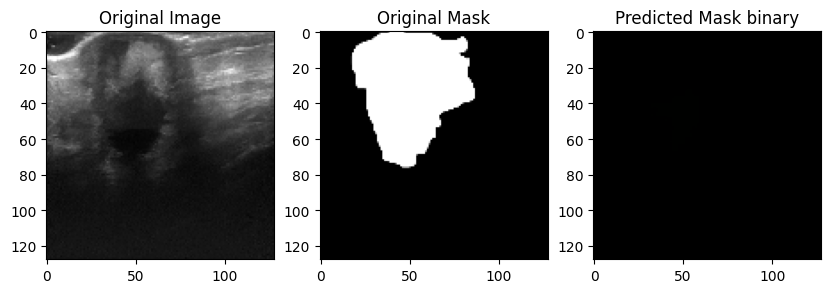

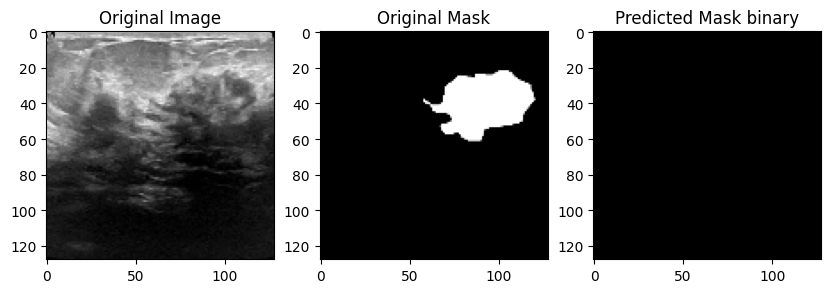

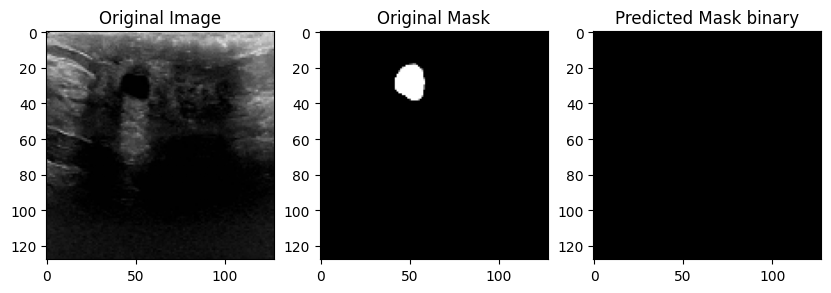

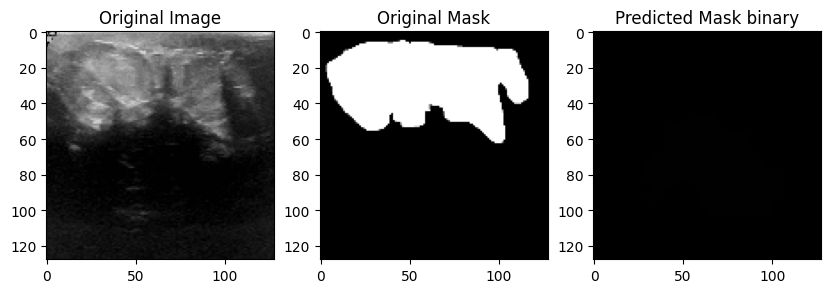

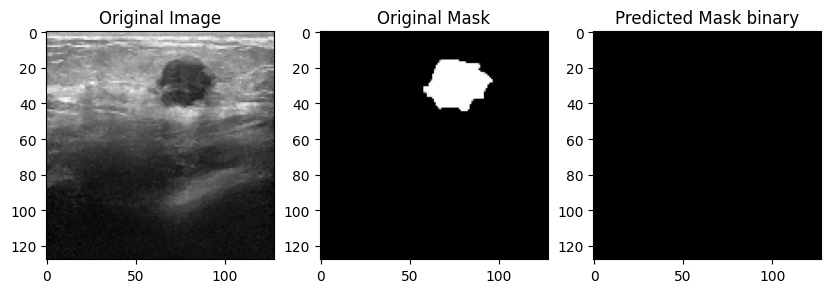

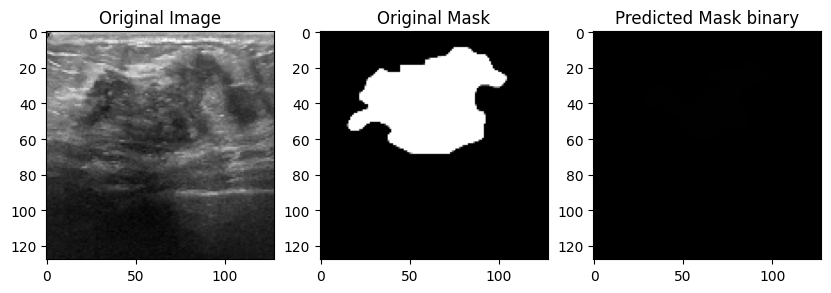

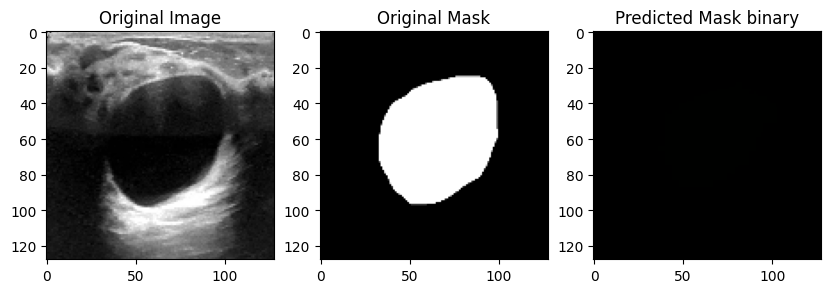

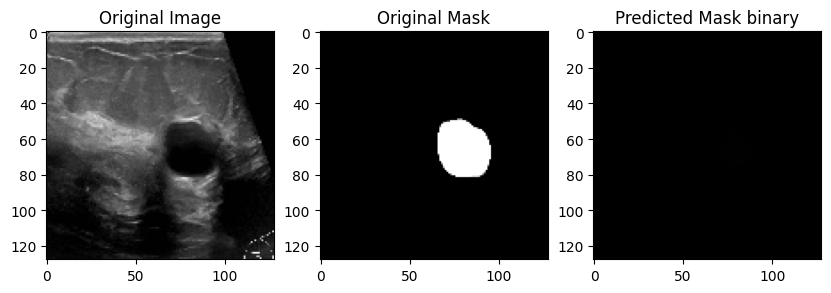

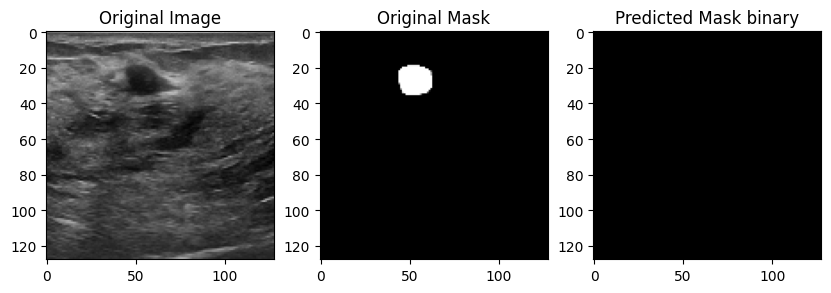

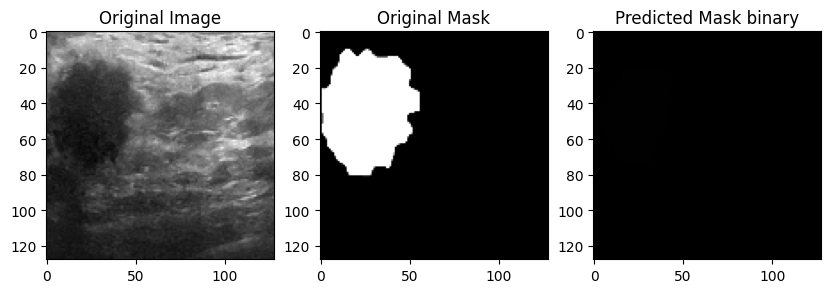

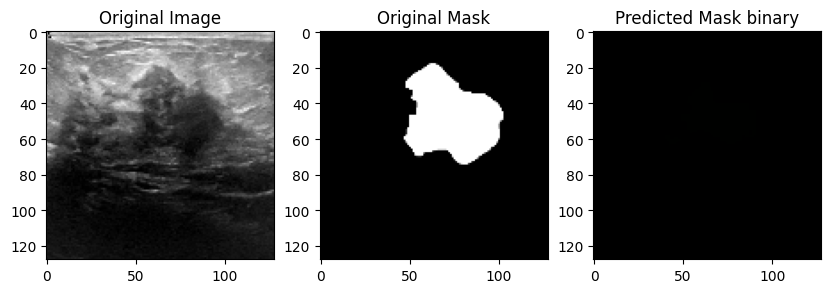

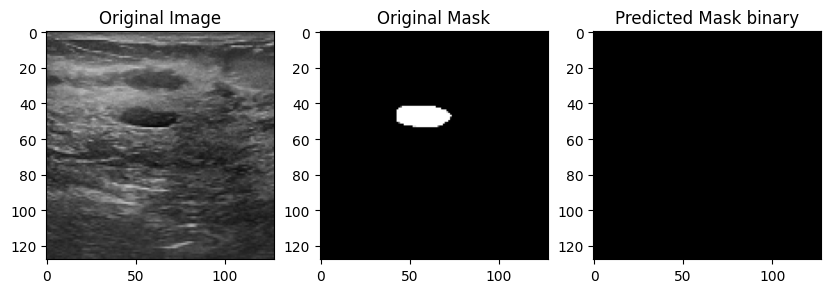

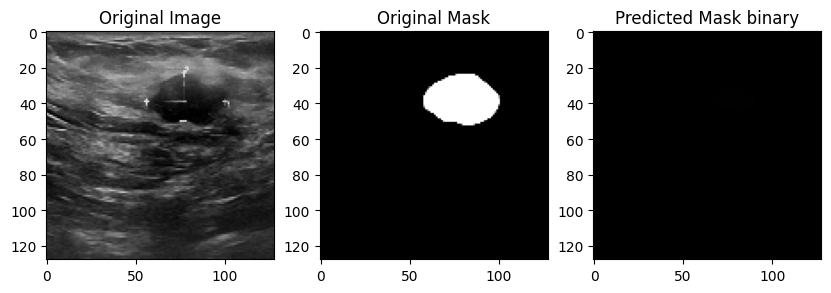

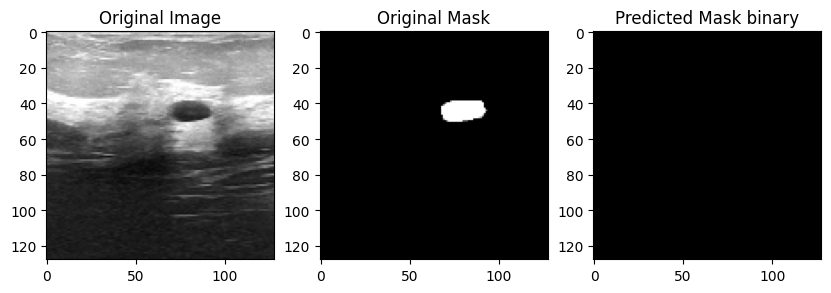

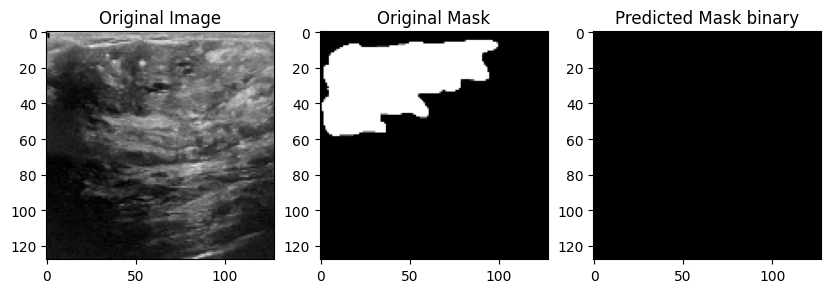

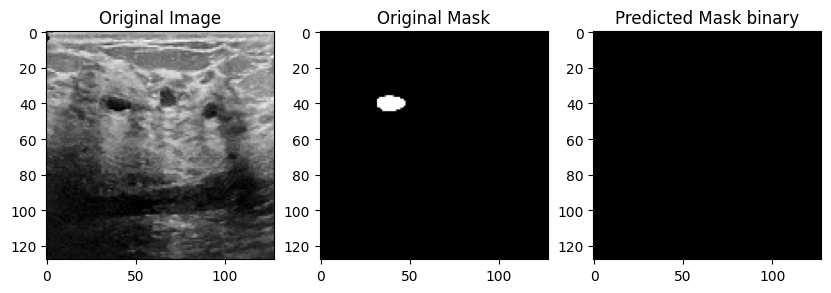

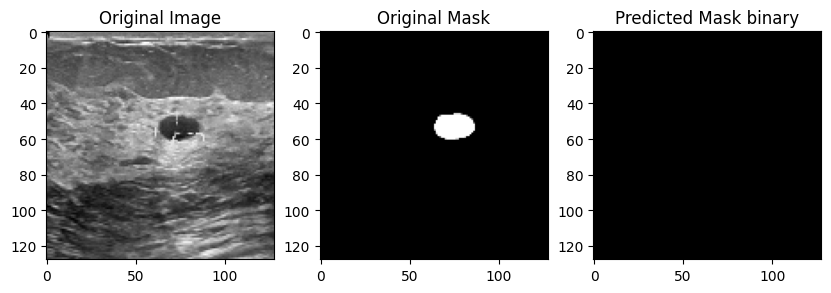

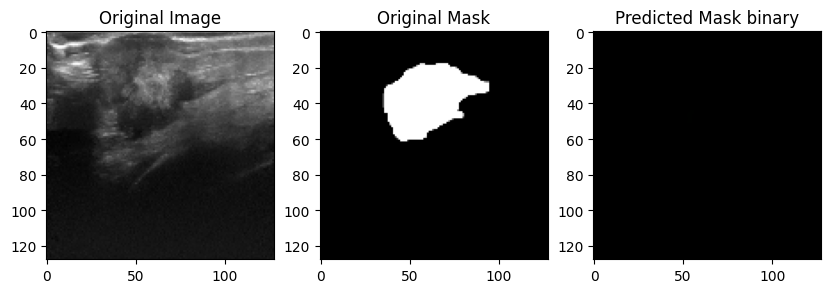

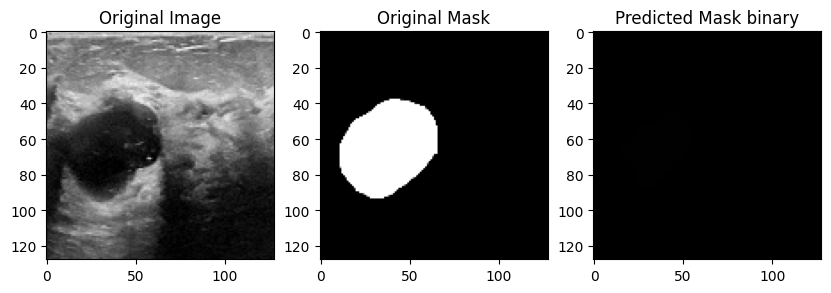

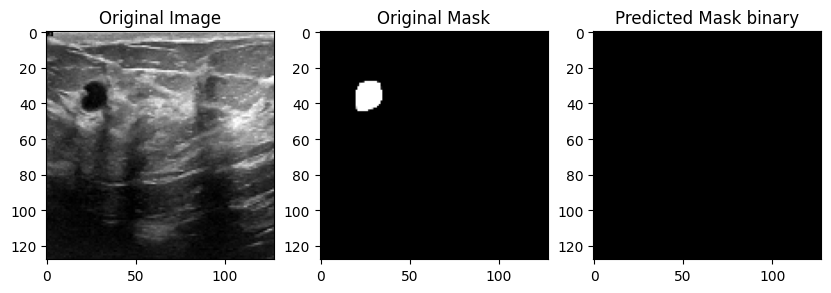

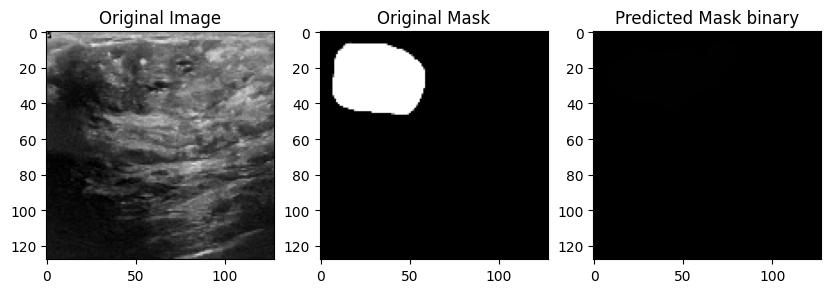

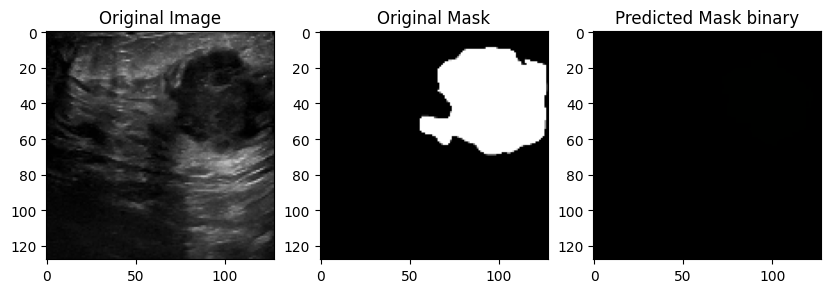

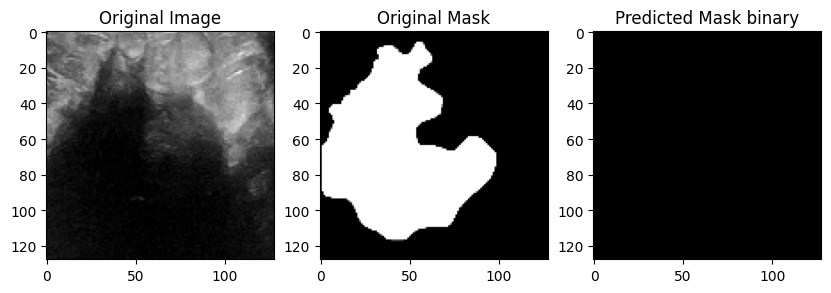

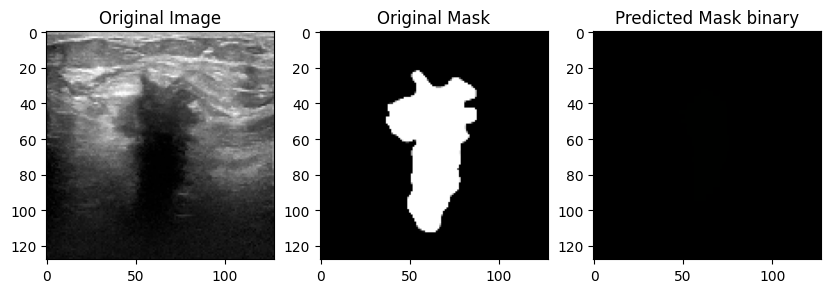

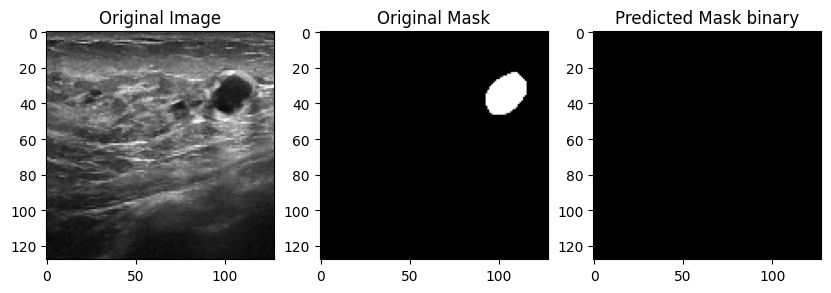

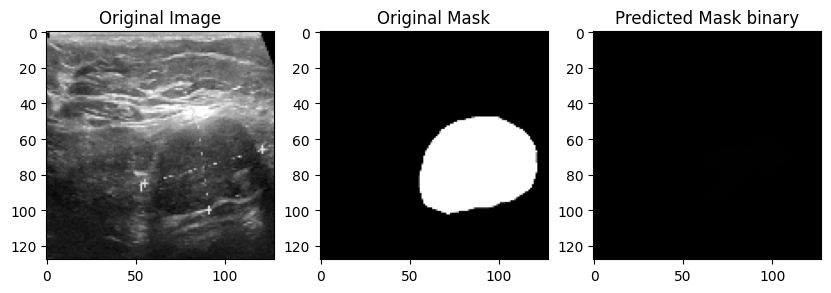

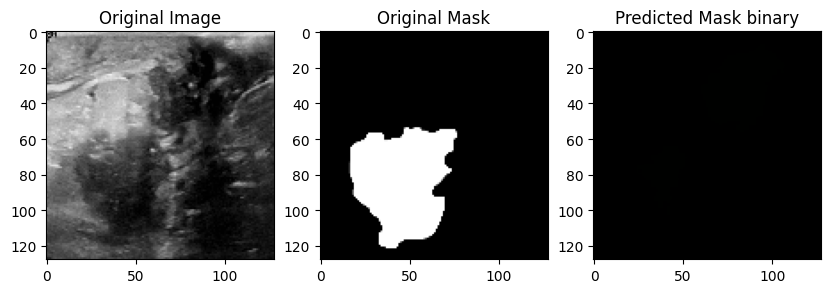

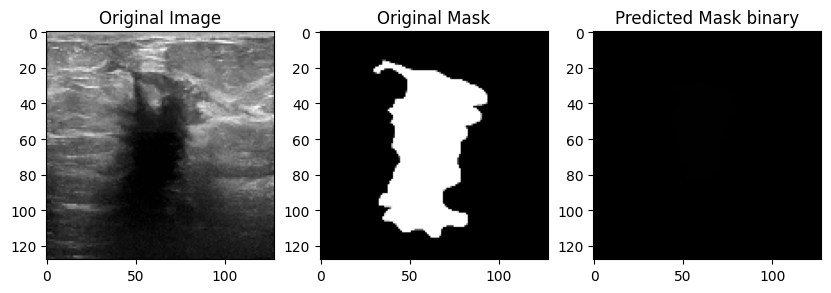

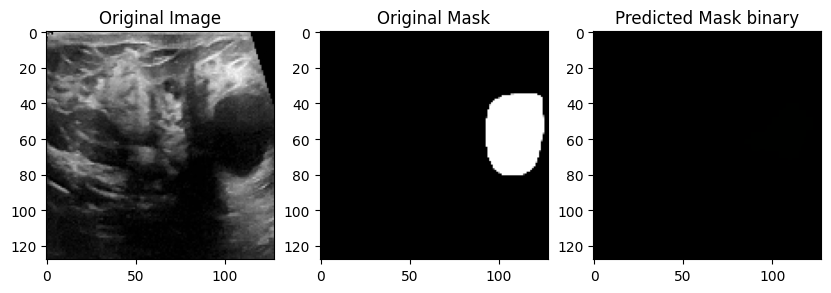

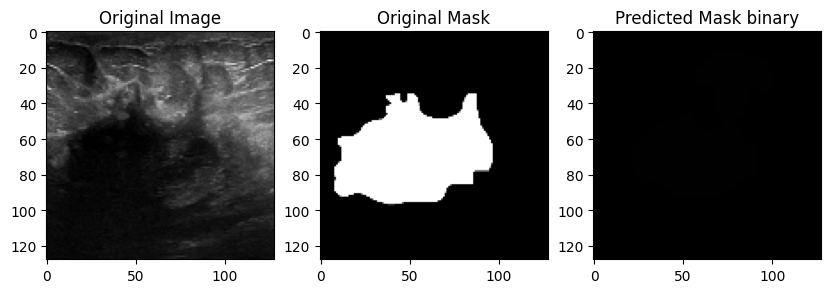

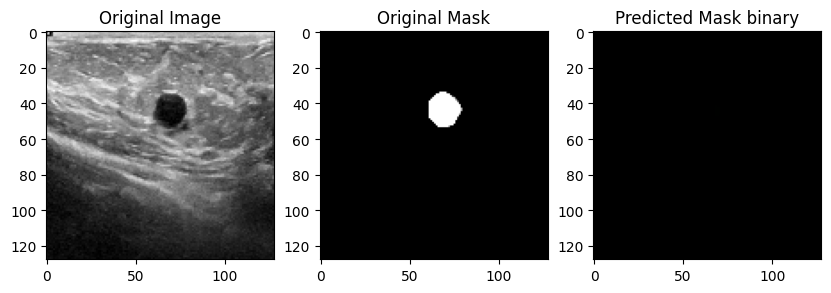

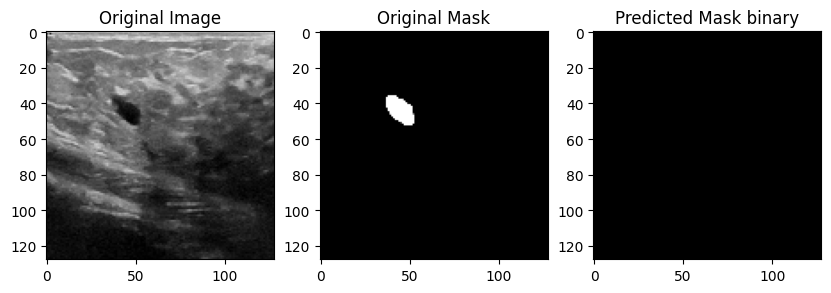

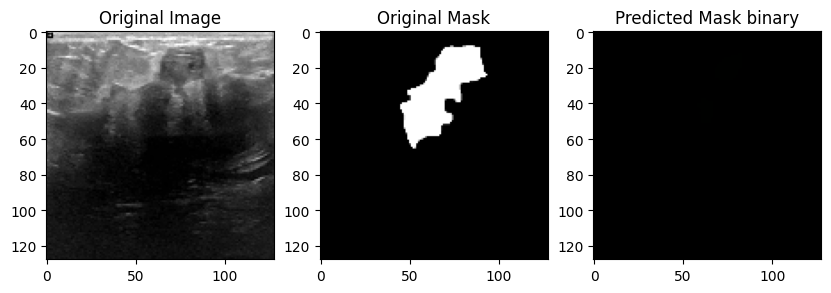

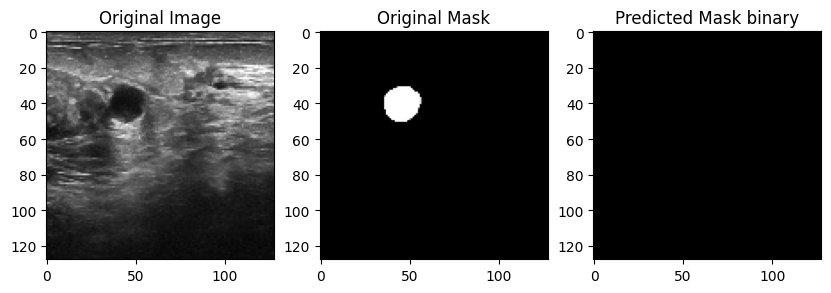

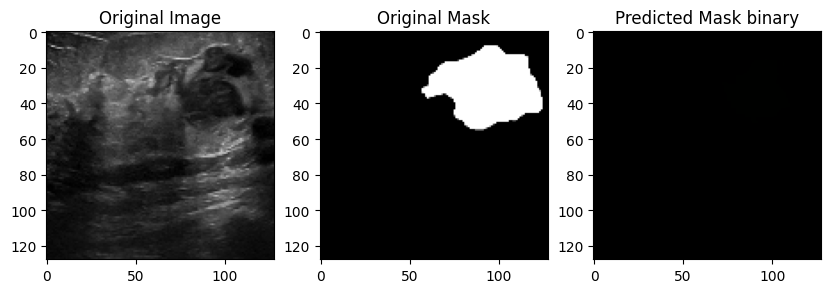

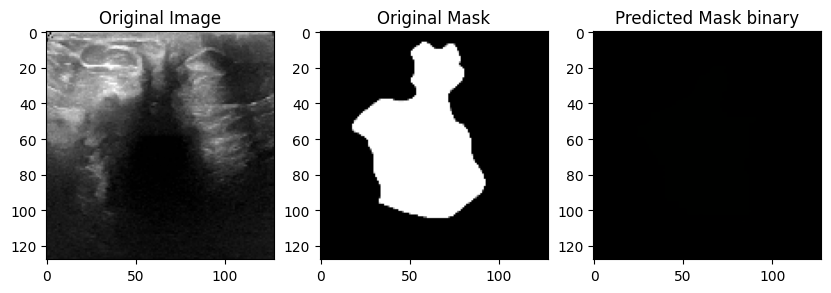

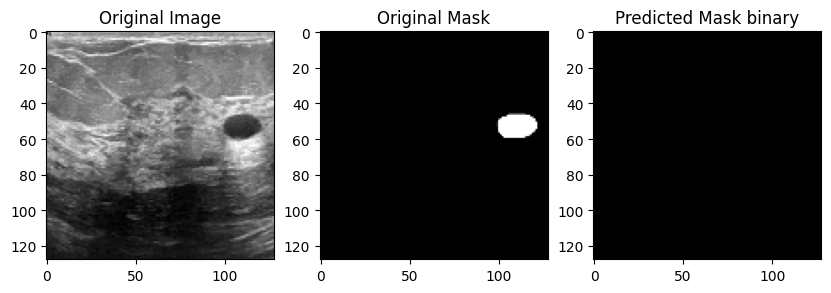

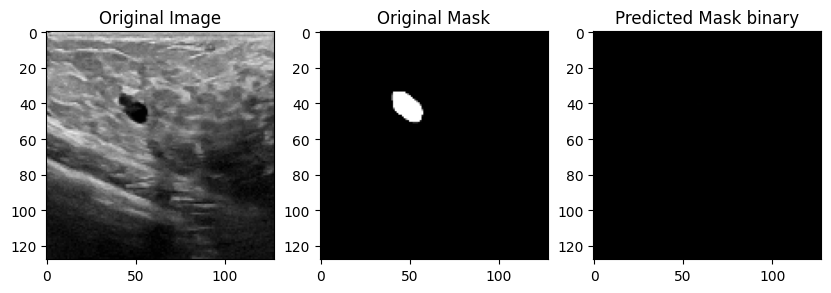

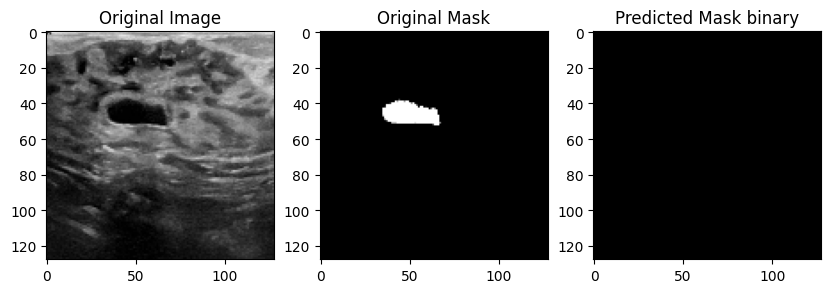

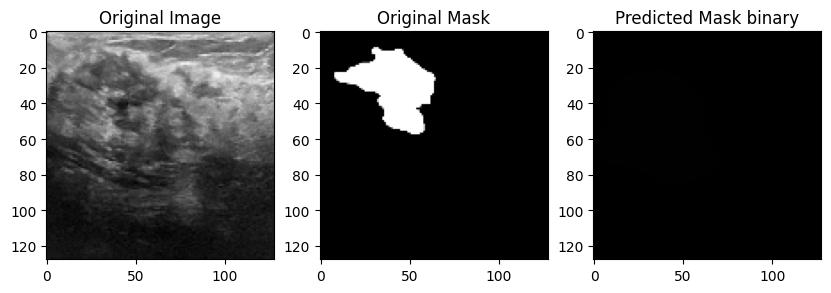

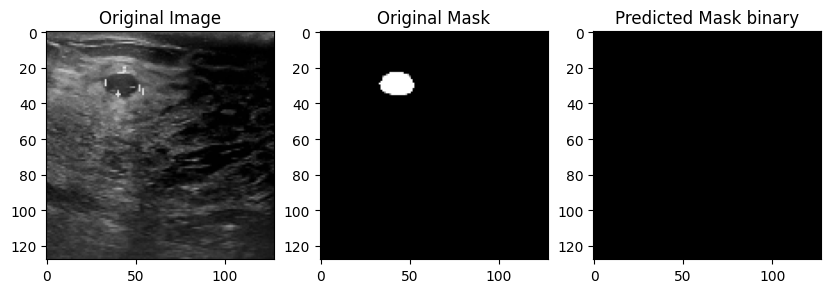

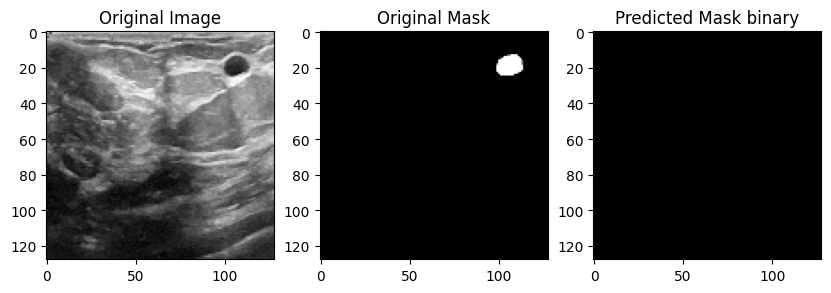

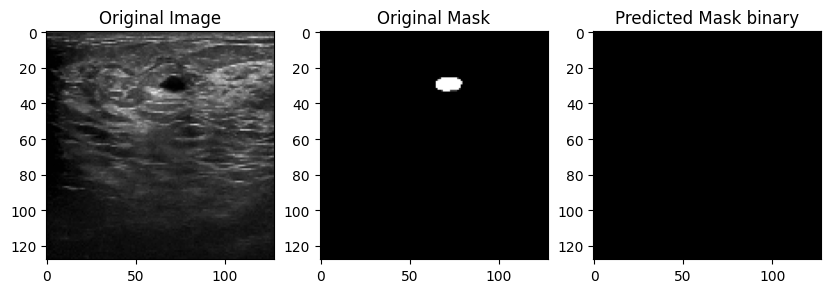

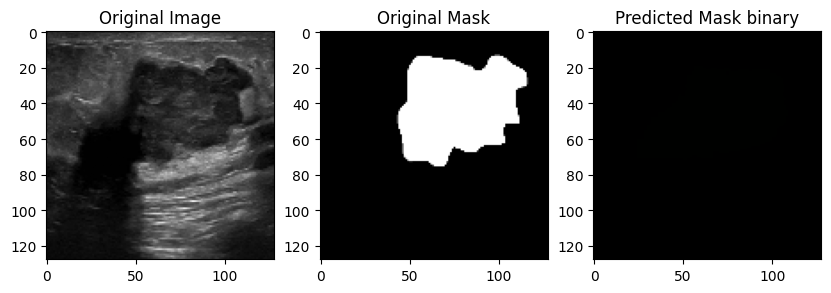

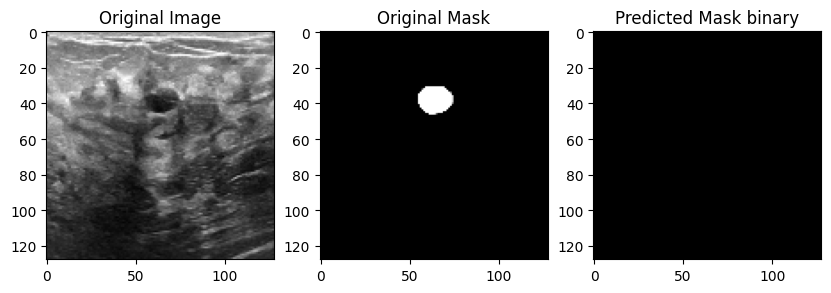

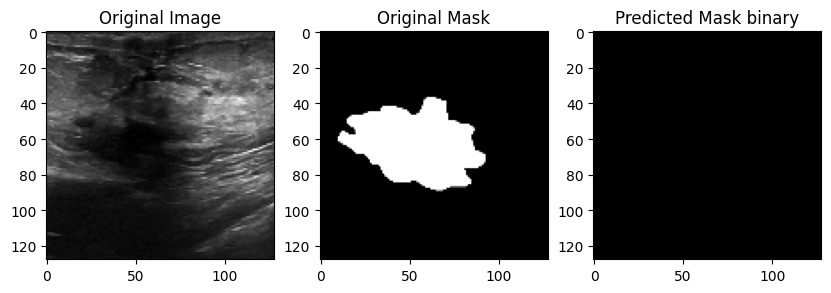

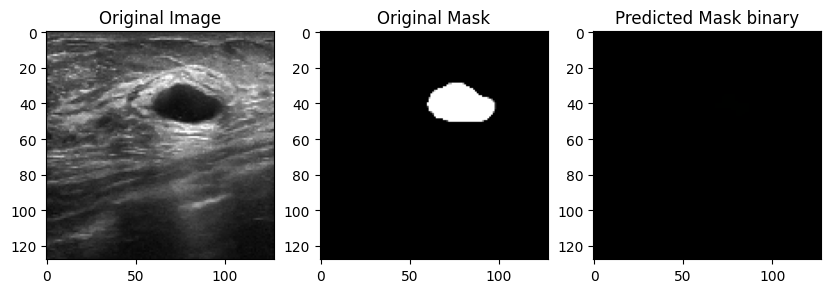

In [33]:
# model.load_weights("{}_Unet_superpixel_chest_slic800.best.hdf5".format('cxr_reg'))
model.load_weights("{}_Unet_superpixel_breast_slic800.best.hdf5".format('cxr_reg'))


import random
dice_scores = []
import matplotlib.colors as mcolors

for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

    # normalize the image and mask to have values between 0 and 1
    test_image = test_image / 255.0
    ground_truth_test_image = ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)

# Convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)


# Make predictions
predicted_masks = model.predict(test_images)

threshold = 0.6  # You can adjust this threshold as needed

# Create an empty list to store the binary masks
binary_masks = []

# Convert the predicted masks to grayscale
# grayscale_mask = np.mean(predicted_masks, axis=-1)

# Apply the threshold to each predicted mask
for i in range(len(predicted_masks)):
    binary_mask = (predicted_masks[i] > threshold).astype(np.uint8)
    binary_masks.append(binary_mask)

# Convert the list of binary masks to a numpy array
binary_masks = np.array(binary_masks)


print("predicted mask grayscale shape:",binary_masks.shape)  # Shape after conversion

print("predicted mask shape:", predicted_masks.shape)
print("test images shape :", test_images.shape)
print ("ground truth test images shape:", ground_truth_test_images.shape)

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef_one_class(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)


for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    precision_value = precision_one_class(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity_one_class(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou_one_class(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)


# Define a custom colormap
cmap_binary = mcolors.ListedColormap(['white', 'black'])  # 'black' for foreground, 'white' for background
n = 69
# Visualize the results for a subset of images

for i in range(n):

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i], cmap='gray')
    ax[1].set_title('Original Mask')
    # ax[2].imshow(predicted_masks[i], cmap="gray")
    # ax[2].set_title('Predicted Mask')
    ax[2].imshow(binary_masks[i], cmap="gray")
    ax[2].set_title('Predicted Mask binary')
    plt.show()
